In [1]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Configurations
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Fetch dataset 
dataset = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = dataset.data.features 
y = dataset.data.targets 

num_classes = len(y.Diagnosis.unique())
num_features = len(X.columns)

In [4]:
set = [X, y]
X = pd.concat(set, axis=1)

In [5]:
# Split dataset into training and testing subsets
def train_test_split(X, test_ratio=0.1, random_seed=None):

    if random_seed:
        random.seed(random_seed)
    
    # Shuffle the indices
    indices = list(range(len(X)))
    random.shuffle(indices)
    
    # Calculate the number of samples for the testing set
    test_size = int(len(X) * test_ratio)
    train_size = len(X) - test_size
    
    # Create the training and testing subsets
    X_train = X.sample(train_size)
    X_test = X.sample(test_size)
    
    return X_train, X_test


X_train, X_test = train_test_split(X, 0.1, 42)

y_train = X_train.Diagnosis
y_train = y_train.to_numpy().reshape(-1, 1)
y_train = np.asarray(y_train, dtype=str)

y_test = X_test.Diagnosis
y_test = y_test.to_numpy().reshape(-1, 1)
y_test= np.asarray(y_test, dtype=str)


In [6]:
# Split data to classes
class_M = X_train[X_train['Diagnosis'] == 'M']
class_B = X_train[X_train['Diagnosis'] == 'B']

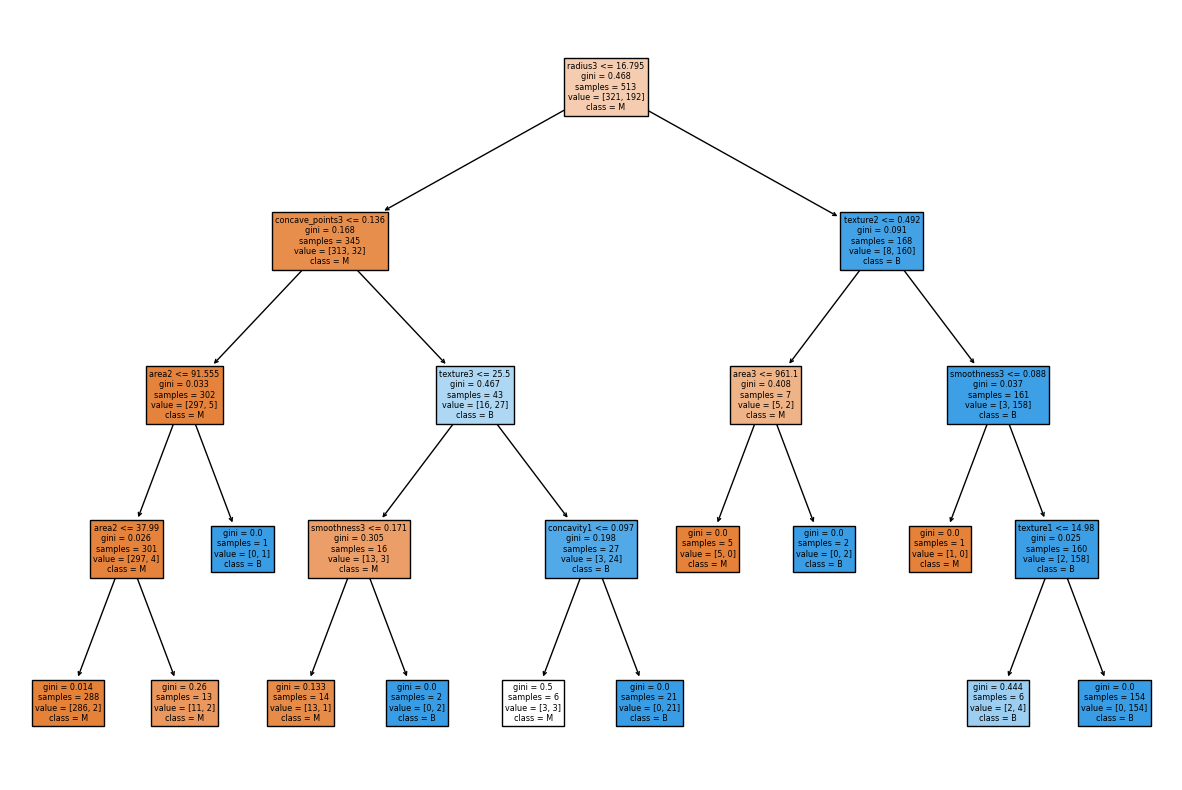

In [7]:
# Train decision tree with tuned depth
from sklearn.tree import DecisionTreeClassifier

depth = 4  # Example depth, you can tune it
tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
tree.fit(X_train.drop('Diagnosis', axis=1), y_train)

# Visualize the tree
plt.figure(figsize=(15, 10))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=["M", "B"])
plt.show()

In [8]:
# Decision Tree Calculate Predictions
y_pred_train = tree.predict(X_train.drop('Diagnosis', axis=1))
y_pred_test = tree.predict(X_test.drop('Diagnosis', axis=1))

# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)

Train Accuracy: 0.9805068226120858
Test Accuracy: 0.9464285714285714


In [9]:
X_train = X_train.drop(columns=['Diagnosis'])
X_test = X_test.drop(columns=['Diagnosis'])

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train_encoded = y_train_encoded.ravel()
y_test_encoded = le.fit_transform(y_test)
y_test_encoded = y_test_encoded.ravel()

# Remove features with zero variance
variance_selector = VarianceThreshold()
X_train_filtered = variance_selector.fit_transform(X_train)
X_test_filtered = variance_selector.transform(X_test)


# Feature selection
k_values = [5, 10, 15, 20]
for k in k_values:
    # Select k best features
    selector = SelectKBest(score_func=f_classif, k=k)
   
    X_train_selected = selector.fit_transform(X_train_filtered, y_train_encoded)
    X_test_selected = selector.transform(X_test_filtered)
    
    # Check if there are non-zero values in denominator for F-value calculation
    if not any(selector.scores_ == 0):
        # Train linear classifier
        lr = LogisticRegression(max_iter=10000, random_state=42)
        lr.fit(X_train_selected, y_train_encoded)

        # Evaluate performance
        y_pred_selected = lr.predict(X_test_selected)
        accuracy_selected = accuracy_score(y_test_encoded, y_pred_selected)
        print(f"Test Accuracy with {k} features:", accuracy_selected)
        print("Selected Features:", X_train.columns[selector.get_support()])
    else:
        print(f"No valid features selected with {k} features.")


Test Accuracy with 5 features: 0.9107142857142857
Selected Features: Index(['perimeter1', 'concave_points1', 'radius3', 'perimeter3',
       'concave_points3'],
      dtype='object')
Test Accuracy with 10 features: 0.9285714285714286
Selected Features: Index(['radius1', 'perimeter1', 'area1', 'concavity1', 'concave_points1',
       'radius3', 'perimeter3', 'area3', 'concavity3', 'concave_points3'],
      dtype='object')


/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy with 15 features: 0.9464285714285714
Selected Features: Index(['radius1', 'perimeter1', 'area1', 'compactness1', 'concavity1',
       'concave_points1', 'radius2', 'perimeter2', 'area2', 'radius3',
       'perimeter3', 'area3', 'compactness3', 'concavity3', 'concave_points3'],
      dtype='object')
Test Accuracy with 20 features: 0.9464285714285714
Selected Features: Index(['radius1', 'texture1', 'perimeter1', 'area1', 'compactness1',
       'concavity1', 'concave_points1', 'radius2', 'perimeter2', 'area2',
       'concave_points2', 'radius3', 'texture3', 'perimeter3', 'area3',
       'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3'],
      dtype='object')


/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed

Number of Trees: 1
Random Forest Training Accuracy: 0.9766081871345029
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 2
Random Forest Training Accuracy: 0.9727095516569201
Random Forest Test Accuracy: 1.0
Number of Trees: 3
Random Forest Training Accuracy: 0.9902534113060428
Random Forest Test Accuracy: 1.0
Number of Trees: 4
Random Forest Training Accuracy: 0.9902534113060428
Random Forest Test Accuracy: 1.0
Number of Trees: 5
Random Forest Training Accuracy: 0.9922027290448343
Random Forest Test Accuracy: 1.0
Number of Trees: 6
Random Forest Training Accuracy: 0.9941520467836257
Random Forest Test Accuracy: 1.0
Number of Trees: 7
Random Forest Training Accuracy: 0.9941520467836257
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 8
Random Forest Training Accuracy: 0.9961013645224172
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 9
Random Forest Training Accuracy: 0.9980506822612085
Random Forest Test Accuracy: 0.9821428571428571
Numb

/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed

Number of Trees: 14
Random Forest Training Accuracy: 0.9980506822612085
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 15
Random Forest Training Accuracy: 0.9980506822612085
Random Forest Test Accuracy: 0.9821428571428571


/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


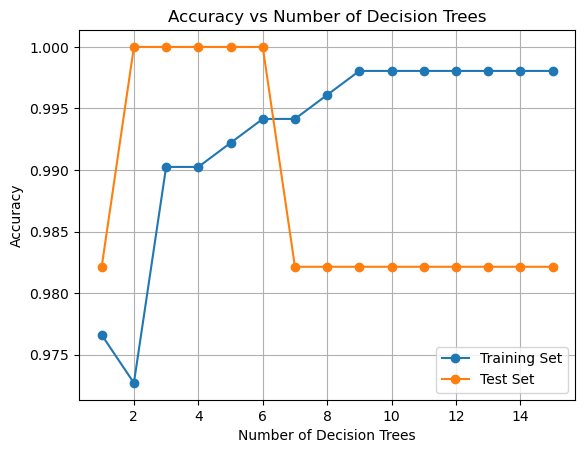

/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed

Number of Trees: 1
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 2
Random Forest Test Accuracy: 1.0
Number of Trees: 3
Random Forest Test Accuracy: 1.0
Number of Trees: 4
Random Forest Test Accuracy: 1.0
Number of Trees: 5
Random Forest Test Accuracy: 1.0
Number of Trees: 6
Random Forest Test Accuracy: 1.0
Number of Trees: 7
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 8
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 9
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 10
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 11
Random Forest Test Accuracy: 0.9821428571428571


/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/brunettow/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed

Number of Trees: 12
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 13
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 14
Random Forest Test Accuracy: 0.9821428571428571
Number of Trees: 15
Random Forest Test Accuracy: 0.9821428571428571


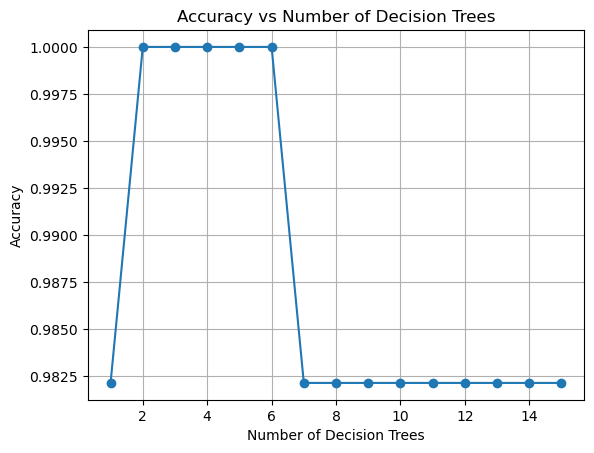

In [23]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

numb_decision_trees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_accuracy = []
test_accuracy = []

for i in numb_decision_trees:
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train, y_train)

    # Training set performance
    y_pred_train_rf = rf.predict(X_train)
    train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
    train_accuracy.append(train_accuracy_rf)

    # Test set performance
    y_pred_rf = rf.predict(X_test)
    test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
    test_accuracy.append(test_accuracy_rf)

    print("Number of Trees:", i)
    print("Random Forest Training Accuracy:", train_accuracy_rf)
    print("Random Forest Test Accuracy:", test_accuracy_rf)

# Plotting the training set and test set accuracy against number of decision trees
plt.plot(numb_decision_trees, train_accuracy, marker='o', label='Training Set')
plt.plot(numb_decision_trees, test_accuracy, marker='o', label='Test Set')
plt.xlabel('Number of Decision Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Decision Trees')
plt.legend()
plt.grid(True)
plt.show()

accuracy = []

for i in numb_decision_trees:
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train, y_train)

    # Test performance comparison
    y_pred_rf = rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracy.append(accuracy_rf)

    print("Number of Trees:", i)
    print("Random Forest Test Accuracy:", accuracy_rf)

# Plotting the accuracy against number of decision trees
plt.plot(numb_decision_trees, accuracy, marker='o')
plt.xlabel('Number of Decision Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Decision Trees')
plt.grid(True)
plt.show()
